# Post processing of Extracted Radiomic Features 

In [1]:
# Intention Hassan transform: Render feature independent of gray level discretization.

In [2]:
import sys
sys.path.append('./../utils/')

import os
import re

import numpy as np
import pandas as pd

import ioutil

from transforms import Whitening
from processing import PostProcessor

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
true_index = np.load('./../../../data_source/patient_id.npy')

In [4]:
# Globals.
FILTER_TYPE = 'original'

## Process Raw Features

In [5]:
ct_feature_files = [
    #'./../../../data_source/radiomic_features/alise/ct_128_no_filter_config.csv',
    './../../../data_source/radiomic_features/no_filter/ct_32_no_filter_config.csv',
    './../../../data_source/radiomic_features/no_filter/ct_64_no_filter_config.csv',
    './../../../data_source/radiomic_features/no_filter/ct_128_no_filter_config.csv',
    #'./../../../data_source/radiomic_features/gauss/ct_32_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/gauss/ct_64_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/gauss/ct_128_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/ct_32_sqroot_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/ct_64_sqroot_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/ct_128_sqroot_config.csv'
]
pet_feature_files = [
    #'./../../../data_source/radiomic_features/alise/pet_16_sqroot_config.csv',
    './../../../data_source/radiomic_features/no_filter/pet_32_no_filter_config.csv',
    './../../../data_source/radiomic_features/no_filter/pet_64_no_filter_config.csv',
    './../../../data_source/radiomic_features/no_filter/pet_128_no_filter_config.csv'
    #'./../../../data_source/radiomic_features/gauss/pet_32_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/gauss/pet_64_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/gauss/pet_128_05gauss_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/pet_32_sqroot_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/pet_64_sqroot_config.csv',
    #'./../../../data_source/radiomic_features/sqroot/pet_128_sqroot_config.csv'
]

In [6]:
ct_processor = PostProcessor(
    path_to_features=ct_feature_files, 
    indices=true_index, 
    filter_type=FILTER_TYPE, 
    error_dir='./../../../data_source/to_analysis/no_filter/errors/'
)

In [7]:
ct_processor.process(drop_redundant=False, drop_missing=True)
ct_processor.to_file(
    path_to_dir='./../../../data_source/to_analysis/no_filter/'
)

Num missing features: 1
Num missing features: 1
Num missing features: 1


In [8]:
pet_processor = PostProcessor(
    path_to_features=pet_feature_files, 
    indices=true_index, 
    filter_type=FILTER_TYPE, 
    error_dir='./../../../data_source/to_analysis/no_filter/errors/'
)

In [9]:
pet_processor.process(drop_redundant=False, drop_missing=True)
pet_processor.to_file(
    path_to_dir='./../../../data_source/to_analysis/no_filter/'
)

In [10]:
ct_features = ct_processor.concatenated
pet_features = pet_processor.concatenated
np.shape(ct_features), np.shape(pet_features)

((198, 273), (198, 276))

## Concatenate Features

In [11]:
shape_feats = pd.read_csv('./../../../data_source/to_analysis/radiomics_shape.csv', index_col=0)
clinical = pd.read_csv('./../../../data_source/to_analysis/clinical_params.csv', index_col=0)
pet_params = pd.read_csv('./../../../data_source/to_analysis/pet_params.csv', index_col=0)

In [12]:
ct_features.columns = ['CT_{}'.format(col) for col in ct_features.columns]
pet_features.columns = ['PET_{}'.format(col) for col in pet_features.columns]

In [13]:
X = pd.concat((shape_feats, clinical, ct_features, pet_features, pet_params), axis=1)
np.shape(X)

(198, 607)

In [14]:
X.to_csv('./../../../data_source/to_analysis/no_filter_concat.csv')

## Feature Decorrelation

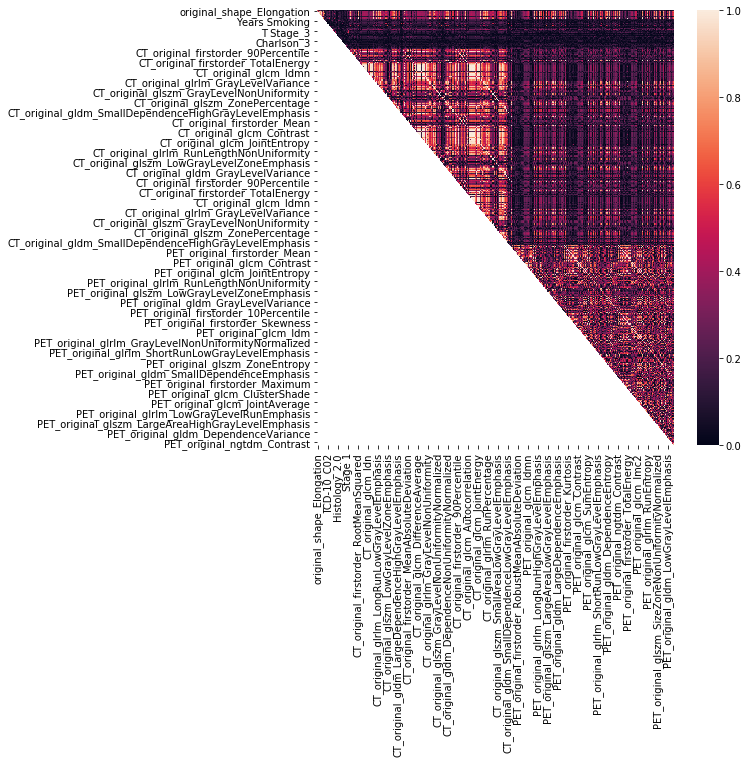

In [15]:
corr_mat_X = X.corr().abs()
# Select upper triangle of correlation matrix
upper_X = corr_mat_X.where(np.triu(np.ones(corr_mat_X.shape), k=1).astype(np.bool))

plt.figure(figsize=(8, 8))
sns.heatmap(upper_X)

In [24]:
# Find feature columns with correlation greater than 0.95
corr_X_feats = [column for column in upper_X.columns if any(upper_X[column] > 0.95)]
len(corr_X_feats)

551

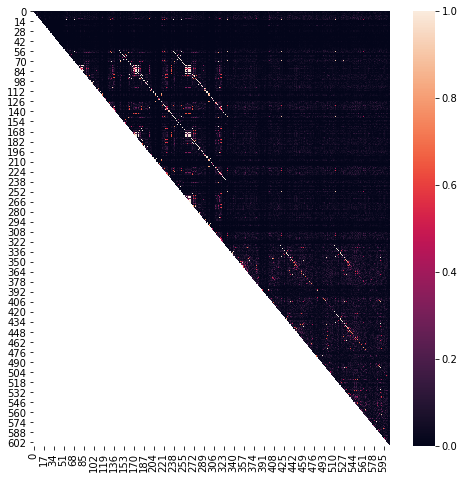

In [17]:
zca_cor = Whitening(method='zca_cor')
Z = zca_cor.fit_transform(X.values)

corr_mat_Z = pd.DataFrame(Z).corr().abs()
# Select upper triangle of correlation matrix
upper_Z = corr_mat_Z.where(np.triu(np.ones(corr_mat_Z.shape), k=1).astype(np.bool))


plt.figure(figsize=(8, 8))
sns.heatmap(upper_Z)

In [27]:
# Find index of feature columns with correlation greater than 0.95
corr_Z_feats = [column for column in upper_Z.columns if any(upper_Z[column] > 0.95)]
len(corr_Z_feats)

254

In [30]:
df_Z = pd.DataFrame(Z, columns=X.columns, index=X.index)
df_Z.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_gldm_SmallDependenceHighGrayLevelEmphasis,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis,PET_original_ngtdm_Busyness,PET_original_ngtdm_Coarseness,PET_original_ngtdm_Complexity,PET_original_ngtdm_Contrast,PET_original_ngtdm_Strength,SUVpeak,MTV,TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,-0.135223,3.141431,0.671594,0.652747,0.869042,-0.179802,1.431932,-1.806326,-0.993516,-1.151420,...,-0.821220,-0.124514,-0.194950,1.330680,0.759446,1.441659,-0.011113,2.951498,0.876162,0.577220
4,-0.039984,1.373478,-0.639334,-0.544190,0.322524,0.503430,0.264753,-0.305280,0.667516,-0.507995,...,-0.116588,-0.800319,-0.335610,-1.004016,-0.132668,0.440059,-0.256506,1.303194,0.435722,0.345692
5,-0.577843,-0.517509,-0.035738,1.791270,-0.765010,-0.371764,0.896314,-1.108682,0.306253,0.710874,...,0.548682,-1.091102,-0.109557,-0.073907,-0.446910,-0.334145,-1.281648,1.007446,-0.492264,-0.676984
8,0.174118,-0.609407,-2.376253,0.210309,-0.736703,0.024354,-0.065029,0.277051,1.487588,-1.086623,...,-0.480541,-0.817004,-0.729207,-0.434551,-0.032812,0.477682,0.634944,0.014648,1.306679,0.686668
10,-0.765245,0.139544,0.414256,-0.541890,-0.743091,0.324775,-0.268823,0.191289,0.228654,-0.633483,...,-0.762971,0.339187,-0.640906,0.047418,0.179805,-0.256022,-1.060255,-0.006911,-0.305710,0.416380


In [31]:
df_Z.to_csv('./../../../data_source/to_analysis/no_filter_concat_zca_cor.csv')